In [7]:
import pandas as pd

source = "https://sites.math.duke.edu/courses/mth390/data/sortition/"
respondents = pd.read_csv(source + "synthetic_respondents.csv")
respondents.head()

,gender,age,ethnicity,education,employment,covid
0,Male,53.0,Turkish,Higher,Student,Yes
1,Male,37.0,Macedonian,Higher,Unemployed,Yes
2,Female,59.0,Roma,Secondary,Unemployed,Yes
3,Male,46.0,Macedonian,Secondary,Employed,Yes
4,Female,68.0,Albanian,Basic,Student,Yes


In [8]:
categories = pd.read_csv(source + "categories.csv")
categories

,category,name,min,max
0,gender,Male,0,20
1,gender,Female,0,20
2,age,18-25,0,8
3,age,25-35,0,8
4,age,35-45,0,14
5,age,45-55,0,5
6,age,55+,0,5
7,ethnicity,Macedonian,0,23
8,ethnicity,Albanian,0,10
9,ethnicity,Turkish,0,2


In [9]:
import numpy as np

# get the age ranges of respondants associated with the given categories
respondents['age_range'] = ["" for _ in range(len(respondents))]
{(18,24):"18-25", (25,34):"25-35", (35,45):"35-44", (45,55):"45-54", (55,200):"55+"}
for ii in respondents.index:
    age = respondents.loc[ii]['age']
    if age < 25:
        respondents.loc[ii, 'age_range'] = "18-25"
    elif age < 35:
        respondents.loc[ii, 'age_range'] = "25-35"
    elif age < 45:
        respondents.loc[ii, 'age_range'] = "35-45"
    elif age < 55:
        respondents.loc[ii, 'age_range'] = "45-55"
    else:
        respondents.loc[ii, 'age_range'] = "55+"

# infer the population fractions given the maximums of the quotas
category_set = set(list(categories['category']))
category_dict = {}

for cat in category_set:
    data = categories[categories.category == cat]
    value2counts = data[["name", "max"]].set_index("name").to_dict()["max"]
    normalizer = sum(value2counts.values())
    value2counts = {k:v/normalizer for (k,v) in value2counts.items()}
    category_dict[cat] = value2counts

category_dict['age_range'] = category_dict['age']
del category_dict['age']

# look at the disparities between the population and pool
for c in respondents.columns:
    if c == "age":
        continue
    data = respondents[c].value_counts(normalize=True)
    data = data.to_dict()
    # data[["name", "max"]].set_index("name").to_dict()["max"]
    for k in category_dict[c].keys():
        print(c, k, "pop:pool:", category_dict[c][k], ":", data[k])
# 

gender Male pop:pool: 0.5 : 0.5366666666666666
gender Female pop:pool: 0.5 : 0.4633333333333333
ethnicity Macedonian pop:pool: 0.575 : 0.49066666666666664
ethnicity Albanian pop:pool: 0.25 : 0.27666666666666667
ethnicity Turkish pop:pool: 0.05 : 0.034666666666666665
ethnicity Roma pop:pool: 0.025 : 0.06266666666666666
ethnicity Serbian pop:pool: 0.025 : 0.03933333333333333
ethnicity Bosnian pop:pool: 0.025 : 0.034
ethnicity Egyptian pop:pool: 0.025 : 0.04066666666666666
ethnicity Other pop:pool: 0.025 : 0.021333333333333333
education Higher pop:pool: 0.4 : 0.49133333333333334
education Secondary pop:pool: 0.4 : 0.43066666666666664
education Basic pop:pool: 0.2 : 0.078
employment Employed pop:pool: 0.325 : 0.5153333333333333
employment Unemployed pop:pool: 0.475 : 0.37
employment Student pop:pool: 0.2 : 0.11466666666666667
covid Yes pop:pool: 0.4 : 0.7193333333333334
covid No pop:pool: 0.6 : 0.2806666666666667
age_range 18-25 pop:pool: 0.2 : 0.054
age_range 25-35 pop:pool: 0.2 : 0.132
a

In [10]:
import cvxpy as cp
import copy

k = 50 # desired panel size
n = len(respondents)

# variable to optimize over is the probabilty associated with each person
pi = cp.Variable(n)
constraints = [0 <= pi, pi <= 1]

# first make simple constraints that just enforce the probability 
# of seeing k paticipants
simple_constraints = constraints + [cp.sum(pi) == k] 

feature_constraints = copy.copy(simple_constraints)
for c in category_dict:
    for v in category_dict[c]:
        target = k*category_dict[c][v]
        indicator = [1 if p==v else 0 for p in list(respondents[c])]
        feature_constraints += [cp.sum(indicator @ pi) == target]

global_min = [k/n for _ in range(n)]
objective_l1 = cp.Minimize(cp.norm(pi - global_min, 1)**1)
objective_l2 = cp.Minimize(cp.norm(pi - global_min, 2)**2)
# objective_nash = cp.Minimize(-cp.prod(pi)) -- will fail! Try it. Why?
objective_nash_log = cp.Minimize(-cp.sum([cp.log(pi[ii]) for ii in range(n)]))
objective_maximin = cp.Minimize(-cp.min(pi))

prob_l1_simple = cp.Problem(objective_l1, simple_constraints)
prob_l1_feature = cp.Problem(objective_l1, feature_constraints)
prob_l2_simple = cp.Problem(objective_l2, simple_constraints)
prob_l2_feature = cp.Problem(objective_l2, feature_constraints)
prob_nl_simple = cp.Problem(objective_nash_log, simple_constraints)
prob_nl_feature = cp.Problem(objective_nash_log, feature_constraints)
prob_mxmn_simple = cp.Problem(objective_maximin, simple_constraints)
prob_mxmn_feature = cp.Problem(objective_maximin, feature_constraints)

sol_l1_simple = prob_l1_simple.solve(); 
pi_l1_simple = copy.copy(pi.value)

sol_l1_feature = prob_l1_feature.solve(); 
pi_l1_feature = copy.copy(pi.value)

sol_l2_simple = prob_l2_simple.solve(); 
pi_l2_simple = copy.copy(pi.value)

sol_l2_feature = prob_l2_feature.solve(); 
pi_l2_feature = copy.copy(pi.value)

sol_nl_simple = prob_nl_simple.solve(); 
pi_nl_simple = copy.copy(pi.value)

sol_nl_feature = prob_nl_feature.solve(); 
pi_nl_feature = copy.copy(pi.value)

sol_mxmn_simple = prob_mxmn_simple.solve(); 
pi_mxmn_simple = copy.copy(pi.value)

sol_mxmn_feature = prob_mxmn_feature.solve(); 
pi_mxmn_feature = copy.copy(pi.value)

ideal = [k/n for _ in range(n)]

print("check that the simply constrained problems give the correct result")
print("Simply constrained nash error:", np.linalg.norm(ideal - pi_nl_simple)/np.linalg.norm(ideal)) 
print("Simply constrained maximin error:", np.linalg.norm(ideal - pi_mxmn_simple)/np.linalg.norm(ideal)) 
print("Simply constrained l1 error:", np.linalg.norm(ideal - pi_l1_simple)/np.linalg.norm(ideal)) 
print("Simply constrained l1 error:", np.linalg.norm(ideal - pi_l2_simple)/np.linalg.norm(ideal)) 

print("Objective Function Values (simple then feature constrained)")
print("Nash: {}, {}".format(sol_nl_simple, sol_nl_feature))
print("Maximin: {}, {}".format(sol_mxmn_simple, sol_mxmn_feature))
print("l1: {}, {}".format(sol_l1_simple, sol_l1_feature))
print("l2: {}, {}".format(sol_l2_simple, sol_l2_feature))

# "check everything sums to k")
assert k-0.5 < sum(pi_l1_simple) < k+0.5
assert k-0.5 < sum(pi_l1_feature) < k+0.5
assert k-0.5 < sum(pi_l2_simple) < k+0.5
assert k-0.5 < sum(pi_l2_feature) < k+0.5
assert k-0.5 < sum(pi_nl_simple) < k+0.5
assert k-0.5 < sum(pi_nl_feature) < k+0.5
assert k-0.5 < sum(pi_mxmn_simple) < k+0.5
assert k-0.5 < sum(pi_mxmn_feature) < k+0.5

check that the simply constrained problems give the correct result
Simply constrained nash error: 2.862115513574057e-08
Simply constrained maximin error: 1.8943180357666756e-14
Simply constrained l1 error: 2.1857515797307795e-14
Simply constrained l1 error: 7.494005416219816e-15
Objective Function Values (simple then feature constrained)
Nash: 5101.796082870993, 6038.863449388292
Maximin: -0.033333333333333964, -0.009097514437159188
l1: 1.0928757898653885e-12, 37.48170360430329
l2: 9.360019529721966e-29, 3.6772487745855105


/Users/domenicfenoglio/Library/Python/3.9/lib/python/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


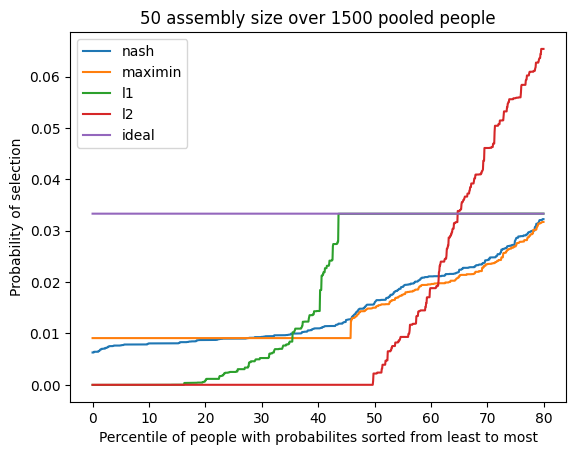

In [11]:
import matplotlib.pyplot as plt

pi_l1_feature.sort()
pi_l2_feature.sort()
pi_mxmn_feature.sort()
pi_nl_feature.sort()

ef = 0.8
x = [ii/n*100 for ii in range(int(ef*n))]
plt.plot(x, pi_nl_feature[:int(n*ef)], label="nash")
plt.plot(x, pi_mxmn_feature[:int(n*ef)], label="maximin")
plt.plot(x, pi_l1_feature[:int(n*ef)], label="l1")
plt.plot(x, pi_l2_feature[:int(n*ef)], label="l2")
plt.plot(x, [k/n for _ in range(int(n*ef))], label="ideal")
plt.xlabel("Percentile of people with probabilites sorted from least to most")
plt.ylabel("Probability of selection")
plt.title("{:} assembly size over {} pooled people".format(k, n))
plt.legend()
plt.show()

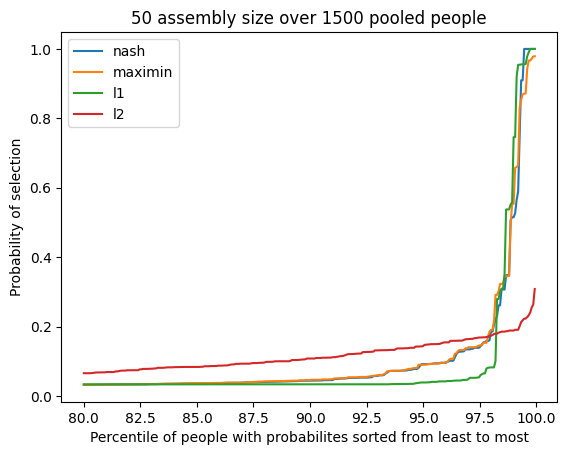

In [12]:
ef = 0.8
x = [ii/n*100 for ii in range(int(ef*n), n)]
plt.plot(x, pi_nl_feature[int(n*ef):n], label="nash")
plt.plot(x, pi_mxmn_feature[int(n*ef):n], label="maximin")
plt.plot(x, pi_l1_feature[int(n*ef):n], label="l1")
plt.plot(x, pi_l2_feature[int(n*ef):n], label="l2")
plt.xlabel("Percentile of people with probabilites sorted from least to most")
plt.ylabel("Probability of selection")
plt.title("{:} assembly size over {} pooled people".format(k, n))
plt.legend()
plt.show()

In [62]:
respondents["L1 Assignments"] = pi_l1_feature
respondents["L2 Assignments"] = pi_l2_feature
respondents["Nash Assignments"] = pi_nl_feature
respondents["Maximin Assignments"] = pi_mxmn_feature
respondents.sort_values('L1 Assignments').head(10)

,gender,age,ethnicity,education,employment,covid,age_range,L1 Assignments,L2 Assignments,Nash Assignments,Maximin Assignments
12,Male,60.0,Albanian,Secondary,Employed,Yes,55+,-0.000023,-3.827753e-14,0.006441,0.009098
13,Female,61.0,Macedonian,Secondary,Unemployed,Yes,55+,-0.000023,-3.827753e-14,0.006441,0.009098
14,Female,19.0,Macedonian,Higher,Employed,No,18-25,-0.000023,-3.827753e-14,0.006441,0.009098
16,Male,35.0,Albanian,Higher,Employed,Yes,35-45,-0.000023,1.441371e-13,0.006585,0.009098
3,Male,46.0,Macedonian,Secondary,Employed,Yes,45-55,-0.000023,-3.426171e-13,0.006294,0.009098
2,Female,59.0,Roma,Secondary,Unemployed,Yes,55+,-0.000023,-3.426171e-13,0.006294,0.009098
1,Male,37.0,Macedonian,Higher,Unemployed,Yes,35-45,-0.000023,-3.426171e-13,0.006294,0.009098
0,Male,53.0,Turkish,Higher,Student,Yes,45-55,-0.000023,-3.426171e-13,0.006294,0.009098
8,Female,29.0,Serbian,Secondary,Unemployed,No,25-35,-0.000023,-1.778817e-13,0.006432,0.009098
9,Male,40.0,Macedonian,Basic,Student,Yes,35-45,-0.000023,-3.827753e-14,0.006432,0.009098


In [14]:
respondents.sort_values('L2 Assignments',ascending=False).head(10)

,gender,age,ethnicity,education,employment,covid,age_range,L1 Assignments,L2 Assignments,Nash Assignments,Maximin Assignments
1499,Female,35.0,Egyptian,Secondary,Employed,Yes,35-45,1.000021,0.308197,1.000000,0.978961
1498,Male,48.0,Albanian,Higher,Employed,Yes,45-55,1.000013,0.263127,1.000000,0.978287
1497,Male,35.0,Albanian,Secondary,Employed,Yes,35-45,1.000011,0.254909,1.000000,0.971459
1496,Male,45.0,Albanian,Higher,Unemployed,Yes,45-55,1.000008,0.240385,1.000000,0.966718
1495,Female,90.0,Macedonian,Secondary,Unemployed,No,55+,0.990150,0.232297,1.000000,0.966459
1494,Female,40.0,Macedonian,Higher,Employed,Yes,35-45,0.978567,0.227127,1.000000,0.942361
1493,Male,46.0,Macedonian,Higher,Employed,Yes,45-55,0.956802,0.222797,0.999998,0.871320
1492,Male,51.0,Albanian,Basic,Employed,Yes,45-55,0.955750,0.222797,0.999983,0.871320
1491,Female,57.0,Macedonian,Secondary,Employed,No,55+,0.955750,0.218006,0.909600,0.869026
1490,Male,68.0,Other,Secondary,Unemployed,Yes,55+,0.955327,0.212836,0.909600,0.853728


In [57]:
respondents.sort_values('Nash Assignments').head(10)

,gender,age,ethnicity,education,employment,covid,age_range,L1 Assignments,L2 Assignments,Nash Assignments,Maximin Assignments
0,Male,53.0,Turkish,Higher,Student,Yes,45-55,-0.000023,-3.426171e-13,0.006294,0.009098
1,Male,37.0,Macedonian,Higher,Unemployed,Yes,35-45,-0.000023,-3.426171e-13,0.006294,0.009098
2,Female,59.0,Roma,Secondary,Unemployed,Yes,55+,-0.000023,-3.426171e-13,0.006294,0.009098
3,Male,46.0,Macedonian,Secondary,Employed,Yes,45-55,-0.000023,-3.426171e-13,0.006294,0.009098
4,Female,68.0,Albanian,Basic,Student,Yes,55+,-0.000023,-1.778817e-13,0.006432,0.009098
5,Male,18.0,Albanian,Higher,Unemployed,Yes,18-25,-0.000023,-1.778817e-13,0.006432,0.009098
6,Male,64.0,Macedonian,Higher,Unemployed,Yes,55+,-0.000023,-1.778817e-13,0.006432,0.009098
7,Male,61.0,Turkish,Secondary,Employed,No,55+,-0.000023,-1.778817e-13,0.006432,0.009098
8,Female,29.0,Serbian,Secondary,Unemployed,No,25-35,-0.000023,-1.778817e-13,0.006432,0.009098
9,Male,40.0,Macedonian,Basic,Student,Yes,35-45,-0.000023,-3.827753e-14,0.006432,0.009098


In [63]:
respondents.sort_values('Maximin Assignments').head(10)

,gender,age,ethnicity,education,employment,covid,age_range,L1 Assignments,L2 Assignments,Nash Assignments,Maximin Assignments
0,Male,53.0,Turkish,Higher,Student,Yes,45-55,-0.000023,-3.426171e-13,0.006294,0.009098
1,Male,37.0,Macedonian,Higher,Unemployed,Yes,35-45,-0.000023,-3.426171e-13,0.006294,0.009098
2,Female,59.0,Roma,Secondary,Unemployed,Yes,55+,-0.000023,-3.426171e-13,0.006294,0.009098
3,Male,46.0,Macedonian,Secondary,Employed,Yes,45-55,-0.000023,-3.426171e-13,0.006294,0.009098
4,Female,68.0,Albanian,Basic,Student,Yes,55+,-0.000023,-1.778817e-13,0.006432,0.009098
5,Male,18.0,Albanian,Higher,Unemployed,Yes,18-25,-0.000023,-1.778817e-13,0.006432,0.009098
6,Male,64.0,Macedonian,Higher,Unemployed,Yes,55+,-0.000023,-1.778817e-13,0.006432,0.009098
7,Male,61.0,Turkish,Secondary,Employed,No,55+,-0.000023,-1.778817e-13,0.006432,0.009098
8,Female,29.0,Serbian,Secondary,Unemployed,No,25-35,-0.000023,-1.778817e-13,0.006432,0.009098
9,Male,40.0,Macedonian,Basic,Student,Yes,35-45,-0.000023,-3.827753e-14,0.006432,0.009098


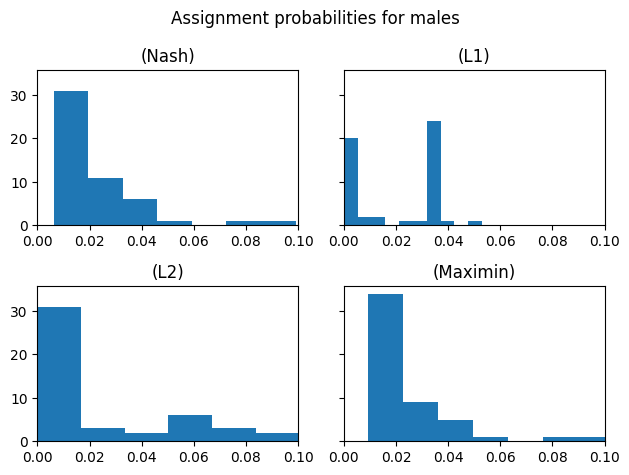

In [ ]:
## TODO: make histograms for lowest probs

Macedonian = respondents[respondents["ethnicity"] == "Macedonian"]
Albanian = respondents[respondents["ethnicity"] == "Albanian"]
Turkish = respondents[respondents["ethnicity"] == "Turkish"]
Roma = respondents[respondents["ethnicity"] == "Roma"]
Serbian = respondents[respondents["ethnicity"] == "Serbian"]
Bosnian = respondents[respondents["ethnicity"] == "Bosnian"]
Egyptian = respondents[respondents["ethnicity"] == "Egyptian"]
Other = respondents[respondents["ethnicity"] == "Other"]

fig, axs = plt.subplots(2, 2, sharey=True, tight_layout=True)
axs = axs.flatten()
axs[0].hist(Turkish["Nash Assignments"])
axs[0].set_title("(Nash)")
axs[1].hist(Turkish["L1 Assignments"])
axs[1].set_title("(L1)")
axs[2].hist(Turkish["L2 Assignments"])
axs[2].set_title("(L2)")
axs[3].hist(Turkish["Maximin Assignments"])
axs[3].set_title("(Maximin)")

for ax in axs:
    ax.set_xlim(0, .1)

fig.suptitle("Assignment probabilities for Turkish individuals")
plt.show()

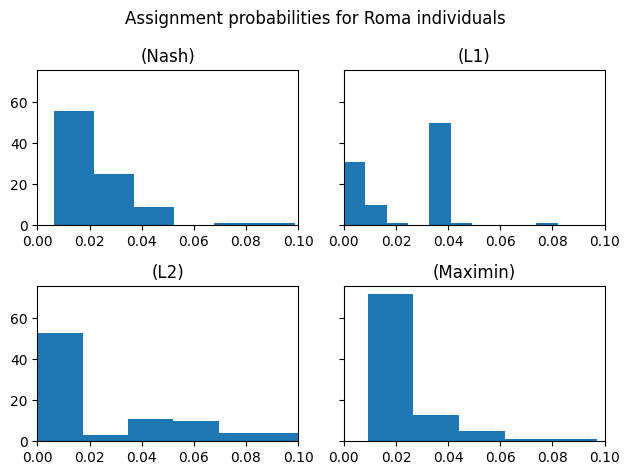

In [ ]:
## TODO: make histograms for lowest probs

Macedonian = respondents[respondents["ethnicity"] == "Macedonian"]
Albanian = respondents[respondents["ethnicity"] == "Albanian"]
Turkish = respondents[respondents["ethnicity"] == "Turkish"]
Roma = respondents[respondents["ethnicity"] == "Roma"]
Serbian = respondents[respondents["ethnicity"] == "Serbian"]
Bosnian = respondents[respondents["ethnicity"] == "Bosnian"]
Egyptian = respondents[respondents["ethnicity"] == "Egyptian"]
Other = respondents[respondents["ethnicity"] == "Other"]

fig, axs = plt.subplots(2, 2, sharey=True, tight_layout=True)
axs = axs.flatten()
axs[0].hist(Roma["Nash Assignments"])
axs[0].set_title("(Nash)")
axs[1].hist(Roma["L1 Assignments"])
axs[1].set_title("(L1)")
axs[2].hist(Roma["L2 Assignments"])
axs[2].set_title("(L2)")
axs[3].hist(Roma["Maximin Assignments"])
axs[3].set_title("(Maximin)")

for ax in axs:
    ax.set_xlim(0, .1)

fig.suptitle("Assignment probabilities for Roma individuals")
plt.show()

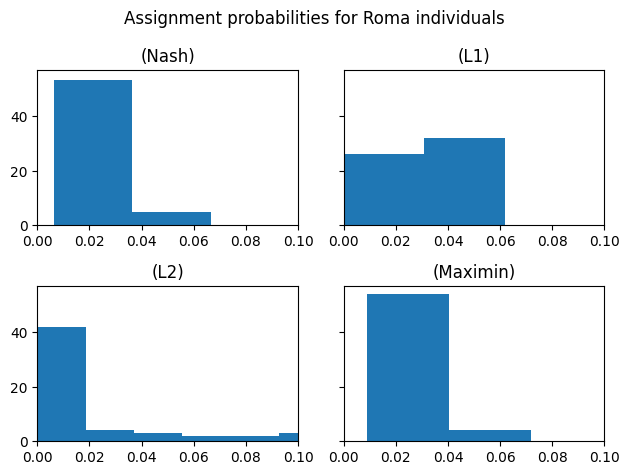

In [ ]:
## TODO: make histograms for lowest probs

Macedonian = respondents[respondents["ethnicity"] == "Macedonian"]
Albanian = respondents[respondents["ethnicity"] == "Albanian"]
Turkish = respondents[respondents["ethnicity"] == "Turkish"]
Roma = respondents[respondents["ethnicity"] == "Roma"]
Serbian = respondents[respondents["ethnicity"] == "Serbian"]
Bosnian = respondents[respondents["ethnicity"] == "Bosnian"]
Egyptian = respondents[respondents["ethnicity"] == "Egyptian"]
Other = respondents[respondents["ethnicity"] == "Other"]

fig, axs = plt.subplots(2, 2, sharey=True, tight_layout=True)
axs = axs.flatten()
axs[0].hist(Serbian["Nash Assignments"])
axs[0].set_title("(Nash)")
axs[1].hist(Serbian["L1 Assignments"])
axs[1].set_title("(L1)")
axs[2].hist(Serbian["L2 Assignments"])
axs[2].set_title("(L2)")
axs[3].hist(Serbian["Maximin Assignments"])
axs[3].set_title("(Maximin)")

for ax in axs:
    ax.set_xlim(0, .1)

fig.suptitle("Assignment probabilities for Serbian individuals")
plt.show()

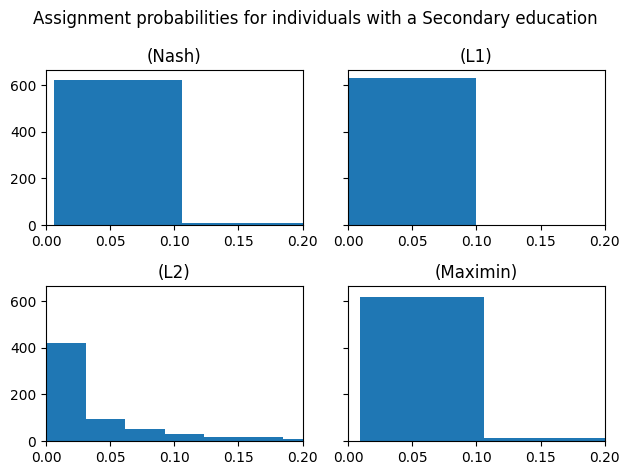

In [105]:
## TODO: make histograms for lowest probs

Basic = respondents[respondents["education"] == "Basic"]
Secondary = respondents[respondents["education"] == "Secondary"]
Higher = respondents[respondents["education"] == "Higher"]


fig, axs = plt.subplots(2, 2, sharey=True, tight_layout=True)
axs = axs.flatten()
axs[0].hist(Secondary["Nash Assignments"])
axs[0].set_title("(Nash)")
axs[1].hist(Secondary["L1 Assignments"])
axs[1].set_title("(L1)")
axs[2].hist(Secondary["L2 Assignments"])
axs[2].set_title("(L2)")
axs[3].hist(Secondary["Maximin Assignments"])
axs[3].set_title("(Maximin)")

for ax in axs:
    ax.set_xlim(0, 0.2)

fig.suptitle("Assignment probabilities for individuals with a Secondary education")
plt.show()

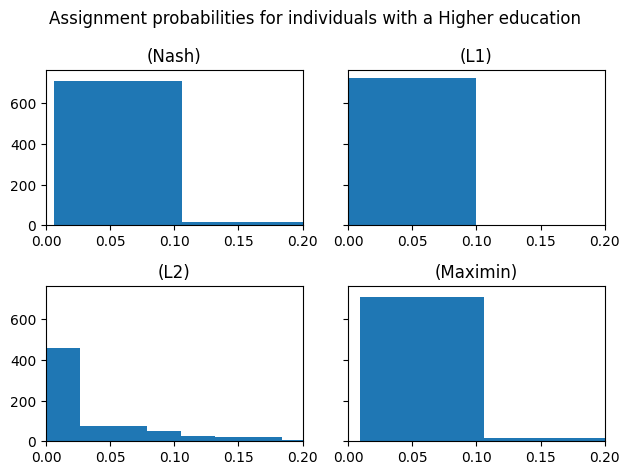

In [104]:
## TODO: make histograms for lowest probs

Basic = respondents[respondents["education"] == "Basic"]
Secondary = respondents[respondents["education"] == "Secondary"]
Higher = respondents[respondents["education"] == "Higher"]


fig, axs = plt.subplots(2, 2, sharey=True, tight_layout=True)
axs = axs.flatten()
axs[0].hist(Higher["Nash Assignments"])
axs[0].set_title("(Nash)")
axs[1].hist(Higher["L1 Assignments"])
axs[1].set_title("(L1)")
axs[2].hist(Higher["L2 Assignments"])
axs[2].set_title("(L2)")
axs[3].hist(Higher["Maximin Assignments"])
axs[3].set_title("(Maximin)")

for ax in axs:
    ax.set_xlim(0, 0.2)

fig.suptitle("Assignment probabilities for individuals with a Higher education")
plt.show()

B) There were some features that were common among the lowest assigned probabilities of all objective functions, such having COVID-19,being in the 55+ age range, and being employed. The main outlier in this regard was the maximin function, which assigned so many people the minimum probability that its feature makeup looks different. However, by looking at the maximin probabilities in our other arrangements, we can see that those assigned the lowest probabilities by other objective functions also recieve the minimum probability under Maximin. 

We can take a further look into assignment probabilites by group by looking at some histograms. While we do not see a signficant difference in the way difference functions assign probabilites to those with COVID, it is clear the L2 function takes a finer tuned approach to both some of the ethnicity and education designations. We could not see this from the graph or from slicing the lowest probabibilities from each group, so it was interesting to see the L2 function behave differently compared to others.

With regards to the individuals assigned the highest probabilities of selection by each objective function, there are also a few features that seem to be important. In particular, younger people without COVID-19 and especially those who are unemployed tend to have a higher probability of selection across objective functions. This makes a lot of sense when looking at the population makeup compared to the sample makeup. We see that 20% of the population is 18-25 while just 5% of the pool is, and 60% of the population does not have COVID-19 while just 28% of the pool doesn't have COVID-19. It is interesting to not that the L2 function is the only one to not assign anyone a probability near 1, likely because of its objective to minimize distance from the "ideal" scenario. In general, each objective function seems to inflate the selection probabilities of individuals with underrepresented features in the pool.

C) I think I prefer the Nash Welfare objective function to assign probabilites of selection, because it preserves the idea of individual fairness -- in the sense that no one has 0% probability of selection -- while also trying to account for differences between the populaiton and the pool. I think that assigning anyone a 0% chance of selection could create a disincentive in electing to participate in the sortition. That ruled out the L1 and L2 norms for me, despite the fact that I liked the L2 function more after looking at some of the histograms. Maybe, if the LP norm was even higher and there were less individuals with 0 probability, I would prefer that. Both the Maximin and Nash Welfare objective functions achieve very similar results and preserve the idea I talked about, but I think I prefer Nash Welfare because of the shape of the graph at the lower end of probability assignments. While they look very similar in the top 80 percentile, I prefer how the Nash Welfare objective function assigns its minimum probabilities to the Maximin.

D) What is this sortition being formed to discuss, and how likely are people to attempt to manipulate their demographic reporting based on the topic? Which demographic is most likely to be manipulated, and what does the current representation look like with our chosen objective function? 